# 短期记忆Memory

In [1]:
! pip install langgraph langchain_core langchain_openai python-dotenv


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## 定义大模型节点

In [2]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import os

load_dotenv()

chat_model = ChatOpenAI(
  api_key=os.getenv('OPENAI_API_KEY'),
  base_url=os.getenv('OPENAI_BASE_URL'),
  model=os.getenv('MODEL_NAME')
)


class State(TypedDict):
    messages: Annotated[list, add_messages]
    
def chat_node(state: State):
  return {"messages": [chat_model.invoke(state["messages"])]}


graph_builder = StateGraph(State)
graph_builder.add_node("chat_node", chat_node)
graph_builder.add_edge(START, "chat_node")
graph_builder.add_edge("chat_node", END)

graph = graph_builder.compile()



## 可视化

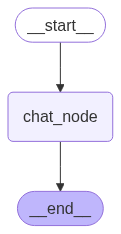

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 不使用Memory调用

In [4]:

def stream_graph_updates(user_input: str):
    print(f"User: {user_input}")
    print(f"==================\n")
    
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


Goodbye!


## 使用Memory调用

In [5]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph

checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

def stream_graph_updates(user_input: str):
    print(f"User: {user_input}")
    print(f"==================\n")
    
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, {"configurable": {"thread_id": "1"}},):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


# 长期记忆 

In [6]:
from langgraph.store.memory import InMemoryStore, BaseStore
from langgraph.graph import StateGraph
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.runnables import RunnableConfig
import uuid

embedding_model_name = os.getenv("EMBEDDING_NAME")
api_key= os.getenv("OPENAI_API_KEY")
base_url = os.getenv("OPENAI_BASE_URL")
print(f"Using embedding model: {embedding_model_name}, API Key: {api_key}, Base URL: {base_url}")

store = InMemoryStore(
    index={
        "dims": 1024,
        "embed": OpenAIEmbeddings(
            base_url=os.getenv("OPENAI_BASE_URL"),
            model=embedding_model_name,
            api_key=os.getenv("OPENAI_API_KEY"),
        ),
    }
)

def call_model(state: State, config: RunnableConfig, *, store: BaseStore):
    # 从存储中检索用户信息
    user_id = config["configurable"]["user_id"]
    # 从存储中检索用户信息
    namespace = ("memories", user_id)
    memories = store.search(namespace, query=str(state["messages"][-1].content))
    info = "\n".join([d.value["data"] for d in memories])
    system_msg = f"你是一个正在与用户交谈的小助手。用户信息：{info}"
    
    # 如果用户要求模型记住信息，则存储新的记忆
    last_message = state["messages"][-1]
    if "记住" in last_message.content or "remember" in last_message.content.lower():
        # 提取用户想要记住的信息
        content = last_message.content
        if "我的名字是" in content:
            name = content.split("我的名字是")[1].strip()
            memory = f"用户的名字是{name}"
        elif "我喜欢" in content:
            hobby = content.split("我喜欢")[1].strip()
            memory = f"用户喜欢{hobby}"
        else:
            memory = content  # 如果无法解析，就存储原始内容
        store.put(namespace, str(uuid.uuid4()), {"data": memory})
    
    response = chat_model.invoke(  # 它实际上会从member里边去提取，提取到了最相关的就是这一条。
        [{"role": "system", "content": system_msg}] + state["messages"]
    )
    return {"messages": response}


builder = StateGraph(State)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", END)
graph = builder.compile(store=store)

Using embedding model: BAAI/bge-m3, API Key: sk-ergndkhlwwhopjyicyysufmfkvbmjxmdcvwlbxvnoloduita, Base URL: https://api.siliconflow.cn/v1


## 测试长期记忆功能

In [ ]:
# 测试长期记忆功能
def test_memory_graph(user_input: str, user_id: str = "user123", thread_id: str = "1"):
    print(f"User: {user_input}")
    print(f"==================\n")
    
    config = {"configurable": {"user_id": user_id, "thread_id": thread_id}}
    
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}]}, 
        config
    ):
        for value in event.values():
            if "messages" in value:
                last_message = value["messages"]
                if hasattr(last_message, 'content'):
                    print("Assistant:", last_message.content)
                elif isinstance(last_message, list) and len(last_message) > 0:
                    print("Assistant:", last_message[-1].content)
                else:
                    print("Assistant:", str(last_message))
    print("\n")

# 测试序列
print("=== 长期记忆测试 ===")
test_memory_graph("你好，请记住我的名字是Barry", "user123", 1)
test_memory_graph("我叫什么名字？", "user123", 1)
test_memory_graph("请记住我喜欢编程", "user123", 1)
# 不同thread_id线程共享内存数据
test_memory_graph("我叫什么名字呢？", "user123", 2)
test_memory_graph("你知道我的兴趣爱好吗？", "user123", 2)

=== 长期记忆测试 ===
User: 你好，请记住我的名字是Barry

Assistant: 你好Barry！很高兴认识你，我已经记住你的名字了。有什么我可以帮助你的吗？


User: 我叫什么名字？



NumPy not found in the current Python environment. The InMemoryStore will use a pure Python implementation for vector operations, which may significantly impact performance, especially for large datasets or frequent searches. For optimal speed and efficiency, consider installing NumPy: pip install numpy


Assistant: 你的名字是Barry。


User: 请记住我喜欢编程

